In [17]:
# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

# Local imports
from datasets import JunkFoodBinaryDataset
from qml.models.binary import BatchedGPUHybridQuantumCNN
from qml.ansatz.dense import DenseQCNNAnsatz4

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [19]:
# Configuration
train_data_folder = "data/data_aug"
test_data_folder = "data/data_noaug"

# Transform
IMAGE_SIZE = 128
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# Load Datasets
train_dataset = JunkFoodBinaryDataset(train_data_folder, transform=transform)
full_test_dataset = JunkFoodBinaryDataset(test_data_folder, transform=transform)

# Determine size of test set to maintain ~80/20 ratio based on training size
# If Train is 80%, then Test should be 25% of Train size (since 20/80 = 1/4)
target_test_size = int(len(train_dataset) * 0.25)
print(f"Training count: {len(train_dataset)}")
print(f"Target Test count (for 80/20 ratio): {target_test_size}")

# Creates a random subset of the clean test data
indices = list(range(len(full_test_dataset)))
random.seed(42) # Ensure consistent test set
random.shuffle(indices)
test_dataset = Subset(full_test_dataset, indices[:target_test_size])

print(f"Actual Test count: {len(test_dataset)}")
print(f"Train/Test Ratio: {len(train_dataset)/(len(train_dataset)+len(test_dataset)):.2f}/{len(test_dataset)/(len(train_dataset)+len(test_dataset)):.2f}")

Training count: 4614
Target Test count (for 80/20 ratio): 1153
Actual Test count: 1153
Train/Test Ratio: 0.80/0.20


In [20]:
# Train/test configuration
BATCH_SIZE = 8
SEED = 42

# Create data loaders
torch.manual_seed(SEED)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training on {len(train_dataset)} augmented images, Testing on {len(test_dataset)} clean images.")

Training on 4614 augmented images, Testing on 1153 clean images.


## Create Quantum CNN Model

In [21]:
# Model configuration
model = BatchedGPUHybridQuantumCNN(
    input_size=IMAGE_SIZE,
    kernel_size=3,
    stride=1,
    pool_size=12,         # Reduces 126x126 -> 12x12 (144 features)
    encoding='dense',
    ansatz=DenseQCNNAnsatz4(),
    n_qubits=4,
    measurement='x',
    hidden_size=[128, 64, 32] # Pyramid: 144->128->64->32->1 (~29k params)
)

model = model.to(device)

Using lightning.qubit device with 'dense' encoding, DenseQCNNAnsatz4, measurement=PauliX
Using default.qubit device with 'dense' encoding, DenseQCNNAnsatz4, measurement=PauliX


## Setup Training

In [22]:
from notebooks.utils import print_model_parameters

# Display model parameter count
print_model_parameters(model)


MODEL PARAMETER COUNT
Total parameters:                28,959
Trainable parameters:            28,959
Non-trainable parameters:             0

Parameter breakdown by layer:
Layer                                    Parameters      Trainable 
-----------------------------------------------------------------
qconv.q_params                           30              Yes       
classical.1.weight                       18,432          Yes       
classical.1.bias                         128             Yes       
classical.4.weight                       8,192           Yes       
classical.4.bias                         64              Yes       
classical.7.weight                       2,048           Yes       
classical.7.bias                         32              Yes       
classical.10.weight                      32              Yes       
classical.10.bias                        1               Yes       


In [23]:
from notebooks.trainer import Trainer

# Training configuration
LEARNING_RATE = 0.003
EPOCHS = 15

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Create trainer
trainer = Trainer(
    criterion=criterion,
    device=device,
    max_grad_norm=1.0,
    log_interval=10
)

## Train Model
With test evaluation after each epoch

In [24]:
results = trainer.train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    test_loader=test_loader
)

Evaluating: 100%|██████████| 145/145 [03:16<00:00,  1.36s/it]


Epoch 1: Train Loss=0.6519, Train Acc=0.6461 | Test Loss=0.6343, Test Acc=0.6826


Evaluating: 100%|██████████| 145/145 [03:03<00:00,  1.27s/it]


Epoch 2: Train Loss=0.6223, Train Acc=0.6749 | Test Loss=0.5826, Test Acc=0.7259


Evaluating: 100%|██████████| 145/145 [03:01<00:00,  1.25s/it]


Epoch 3: Train Loss=0.5965, Train Acc=0.7035 | Test Loss=0.5734, Test Acc=0.7398


Evaluating: 100%|██████████| 145/145 [03:00<00:00,  1.24s/it]


Epoch 4: Train Loss=0.5784, Train Acc=0.7161 | Test Loss=0.5251, Test Acc=0.7320


Evaluating: 100%|██████████| 145/145 [02:53<00:00,  1.20s/it]


Epoch 5: Train Loss=0.5603, Train Acc=0.7289 | Test Loss=0.4912, Test Acc=0.7624


Evaluating: 100%|██████████| 145/145 [02:58<00:00,  1.23s/it]


Epoch 6: Train Loss=0.5356, Train Acc=0.7490 | Test Loss=0.4640, Test Acc=0.7806


Evaluating: 100%|██████████| 145/145 [03:01<00:00,  1.25s/it]


Epoch 7: Train Loss=0.5056, Train Acc=0.7705 | Test Loss=0.4238, Test Acc=0.8109


Evaluating: 100%|██████████| 145/145 [03:00<00:00,  1.25s/it]


Epoch 8: Train Loss=0.4728, Train Acc=0.7926 | Test Loss=0.4851, Test Acc=0.7762


Evaluating: 100%|██████████| 145/145 [02:59<00:00,  1.24s/it]


Epoch 9: Train Loss=0.4558, Train Acc=0.7971 | Test Loss=0.4286, Test Acc=0.8153


Evaluating: 100%|██████████| 145/145 [02:56<00:00,  1.22s/it]


Epoch 10: Train Loss=0.4496, Train Acc=0.8030 | Test Loss=0.4011, Test Acc=0.8205


Evaluating: 100%|██████████| 145/145 [03:02<00:00,  1.26s/it]


Epoch 11: Train Loss=0.4113, Train Acc=0.8314 | Test Loss=0.4410, Test Acc=0.7936


Evaluating: 100%|██████████| 145/145 [03:01<00:00,  1.25s/it]


Epoch 12: Train Loss=0.4088, Train Acc=0.8277 | Test Loss=0.4052, Test Acc=0.8491


Evaluating: 100%|██████████| 145/145 [03:01<00:00,  1.25s/it]


Epoch 13: Train Loss=0.3836, Train Acc=0.8416 | Test Loss=0.3998, Test Acc=0.8283


Evaluating: 100%|██████████| 145/145 [03:00<00:00,  1.25s/it]


Epoch 14: Train Loss=0.3863, Train Acc=0.8433 | Test Loss=0.3555, Test Acc=0.8647


Evaluating: 100%|██████████| 145/145 [02:59<00:00,  1.24s/it]

Epoch 15: Train Loss=0.3667, Train Acc=0.8533 | Test Loss=0.3361, Test Acc=0.8682


## Train results

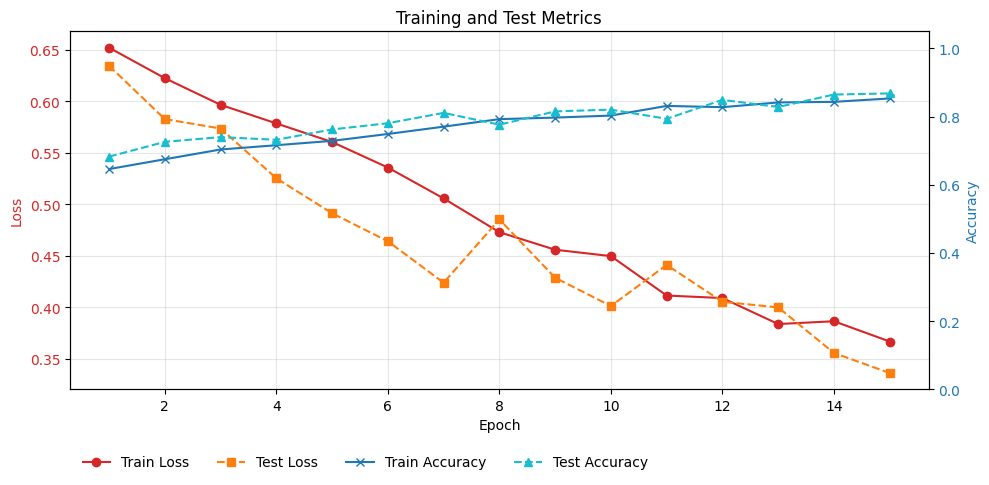

In [25]:
from notebooks.utils import plot_loss_and_accuracy

plot_loss_and_accuracy(
    losses=results['train_loss'],
    accuracies=results['train_acc'],
    test_losses=results['test_loss'],
    test_accuracies=results['test_acc']
)

Evaluating: 100%|██████████| 145/145 [02:58<00:00,  1.23s/it]



Final Test Results:
Test Loss: 0.3361
Test Accuracy: 0.8682


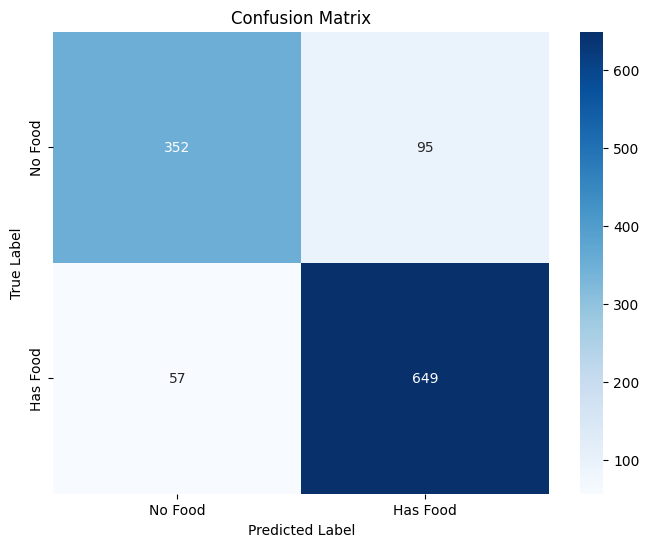


Detailed Metrics:
Precision: 0.8723
Recall: 0.9193
F1 Score: 0.8952

Confusion Matrix:
True Negatives:  352
False Positives: 95
False Negatives: 57
True Positives:  649


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on test set
(test_loss, test_acc), confusion_matrix = trainer.evaluate(model, test_loader)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Food', 'Has Food'], 
            yticklabels=['No Food', 'Has Food'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Print detailed metrics
tn, fp, fn, tp = confusion_matrix.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nDetailed Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"\nConfusion Matrix:")
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")